# Task 1 — Quantum Arithmetics

## Task 1.1  - Increment and Decrement Operator

In [ ]:
# install and imports
!pip install -q "qiskit>=2.1" qiskit-aer

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# get state vector of circuit
def sv_from_circ(circ: QuantumCircuit) -> np.ndarray:
    sv = Statevector(circ)
    return np.asarray(sv, dtype=np.complex128)

# circle notation visualiser
class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk: radius ∝ sqrt(probability) so area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00


### Superposition of Quantum States: HAD gate on only 1 out of 2 qubits

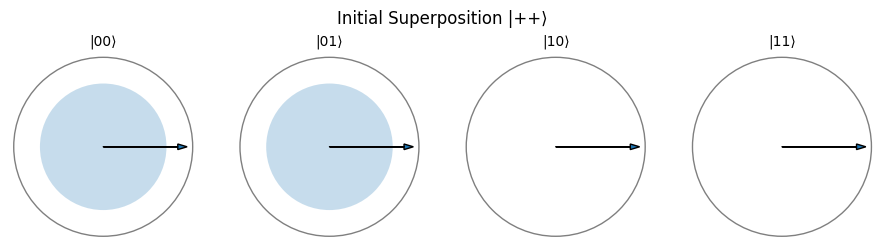

In [ ]:
# create superposition on 1 qubit
qc = QuantumCircuit(2)
qc.h(0)         # Hadamard: only qubit 0 in superposition
qc.draw("text")

# Convert to statevector
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial Superposition |++⟩")
qs.viz_circle()


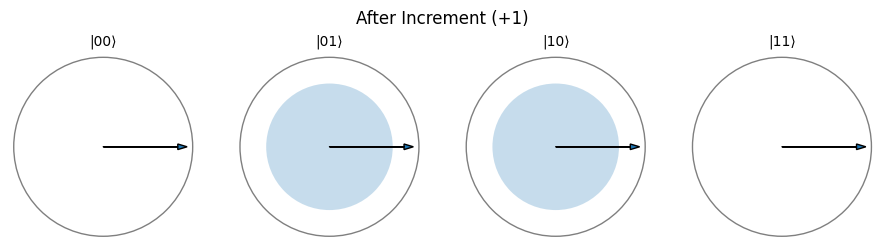

In [ ]:
# Increment Operator
def increment(sv: np.ndarray) -> np.ndarray:
    n = len(sv)
    new_sv = np.zeros_like(sv)
    for i in range(n):
        new_sv[(i+1) % n] = sv[i]
    return new_sv

sv_inc = increment(sv)
qs_inc = QubitSystem(sv_inc, label="After Increment (+1)")
qs_inc.viz_circle()


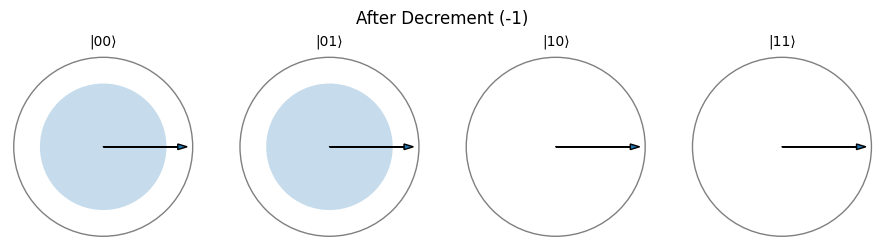

In [ ]:
# Decrement Operator
def decrement(sv: np.ndarray) -> np.ndarray:
    n = len(sv)
    new_sv = np.zeros_like(sv)
    for i in range(n):
        new_sv[(i-1) % n] = sv[i]
    return new_sv

sv_dec = decrement(sv_inc)
qs_dec = QubitSystem(sv_dec, label="After Decrement (-1)")
qs_dec.viz_circle()


### Superposition of Quantum States: HAD gate on one qubit and phase modification

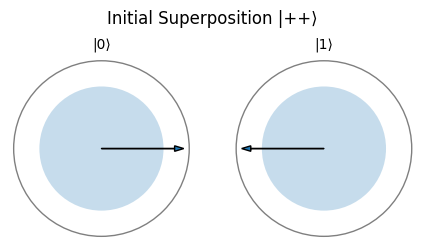

In [ ]:
# with differing phase
qc = QuantumCircuit(1)
qc.h(0)
qc.z(0)         # adds phase π to |1⟩

# Convert to statevector
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial Superposition |++⟩")
qs.viz_circle()

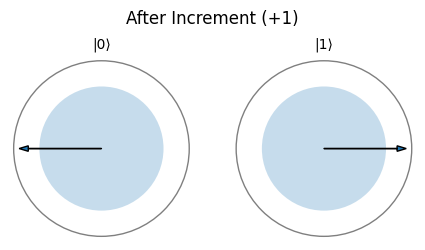

In [ ]:
# Increment Operator
sv_inc = increment(sv)
qs_inc = QubitSystem(sv_inc, label="After Increment (+1)")
qs_inc.viz_circle()


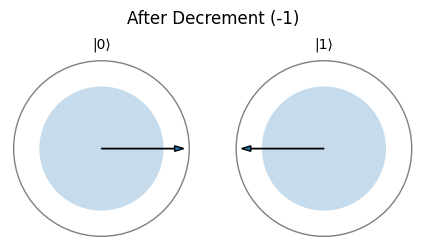

In [ ]:
# Decrement Operator
sv_dec = decrement(sv_inc)
qs_dec = QubitSystem(sv_dec, label="After Decrement (-1)")
qs_dec.viz_circle()


## Task 1.2 - Overflow & Underflow / Negative Numbers

1. What happens if we have an overflow (for the increment) or underflow (for the decrement)? Show the results of the overflow and underflow with an experiment.

Where there is overflow or underflow, we typically expect a wrap back around the state vector.

In [ ]:
# Extension of Increment and Decrement Operations to print when Overflow or Underflow occurs

# Increment Operator with overflow logging
def increment(sv: np.ndarray) -> np.ndarray:
    n = len(sv)
    new_sv = np.zeros_like(sv)
    for i in range(n):
        new_index = (i + 1) % n
        new_sv[new_index] = sv[i]
        if new_index == 0 and abs(sv[i]) > 1e-12:  # nonzero amplitude wrapped
            print(f"⚠️ Overflow: amplitude from basis state {i} wrapped around to 0")
    return new_sv

# Decrement Operator with underflow logging
def decrement(sv: np.ndarray) -> np.ndarray:
    n = len(sv)
    new_sv = np.zeros_like(sv)
    for i in range(n):
        new_index = (i - 1) % n
        new_sv[new_index] = sv[i]
        if new_index == n-1 and abs(sv[i]) > 1e-12:  # nonzero amplitude wrapped
            print(f"⚠️ Underflow: amplitude from basis state {i} wrapped around to {n-1}")
    return new_sv



In [ ]:
# Start in |00>
sv = np.array([1,0,0,0], dtype=np.complex128)

print("Original:", sv)

Original: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]


### Overflow for the Increment

In [ ]:
# Increment 4 times
for k in range(4):
    sv = increment(sv)
    print(f"After increment {k+1}:", sv)

After increment 1: [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
After increment 2: [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
After increment 3: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
⚠️ Overflow: amplitude from basis state 3 wrapped around to 0
After increment 4: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]


### Underflow for the Decrement

In [ ]:
# Decrement 1 time
sv = decrement(sv)
print("After one decrement:", sv)

⚠️ Underflow: amplitude from basis state 0 wrapped around to 3
After one decrement: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


### Visualisation of Overflow and Underflow with Circle Notation

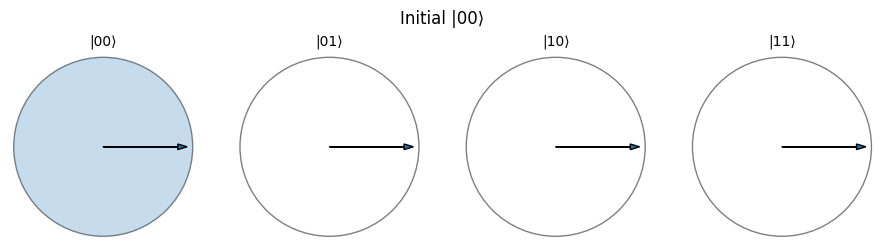

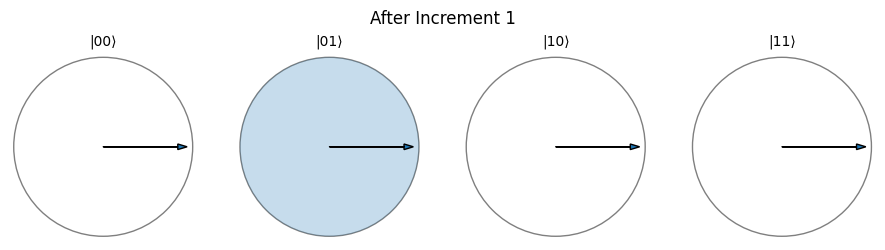

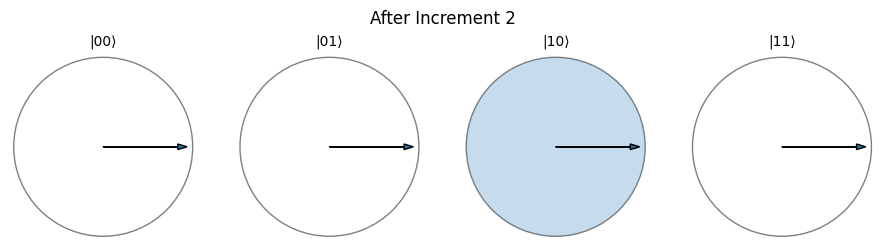

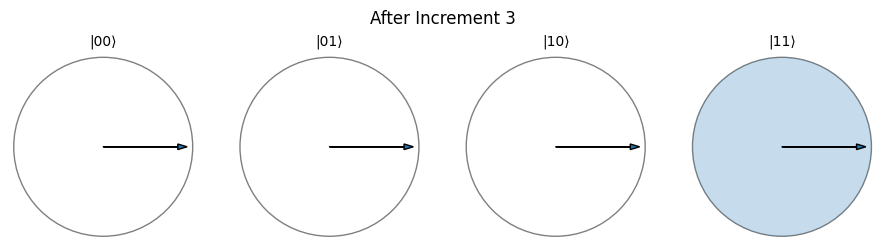

⚠️ Overflow: amplitude from basis state 3 wrapped around to 0


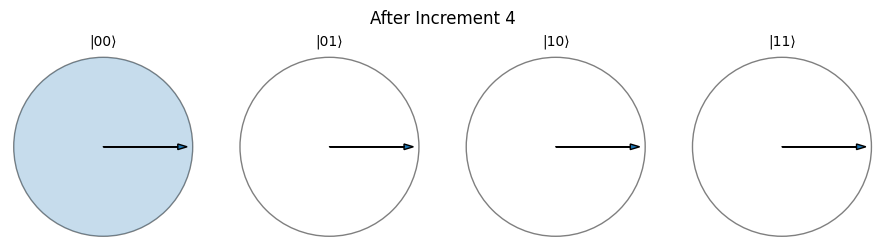

⚠️ Underflow: amplitude from basis state 0 wrapped around to 3


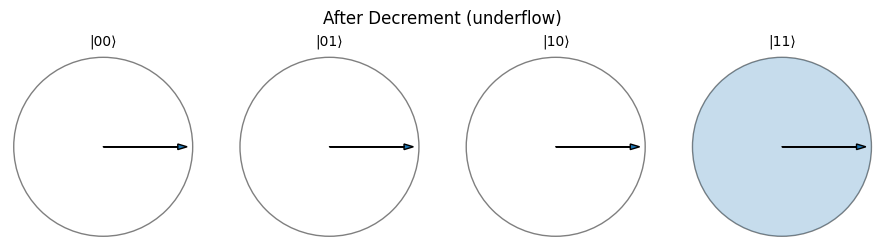

In [ ]:
qs = QubitSystem(np.array([1,0,0,0]), label="Initial |00⟩")
qs.viz_circle()

# Increment 4 times
sv_inc = np.array([1,0,0,0], dtype=np.complex128)
for k in range(4):
    sv_inc = increment(sv_inc)
    qs_inc = QubitSystem(sv_inc, label=f"After Increment {k+1}")
    qs_inc.viz_circle()

# Decrement once (show underflow)
sv_dec = decrement(sv_inc)
qs_dec = QubitSystem(sv_dec, label="After Decrement (underflow)")
qs_dec.viz_circle()


2. Do increment and decrement operations also work with negative integer numbers? Motivate with an example.



Yes, increment and decrement can work with negative integers,
but only if we define an encoding (such as two’s complement).

In two’s complement, for a given number bits, half the values are associated with negative numbers, and half with positive numbers.

### Using Two's Complement to represent Negative Integers

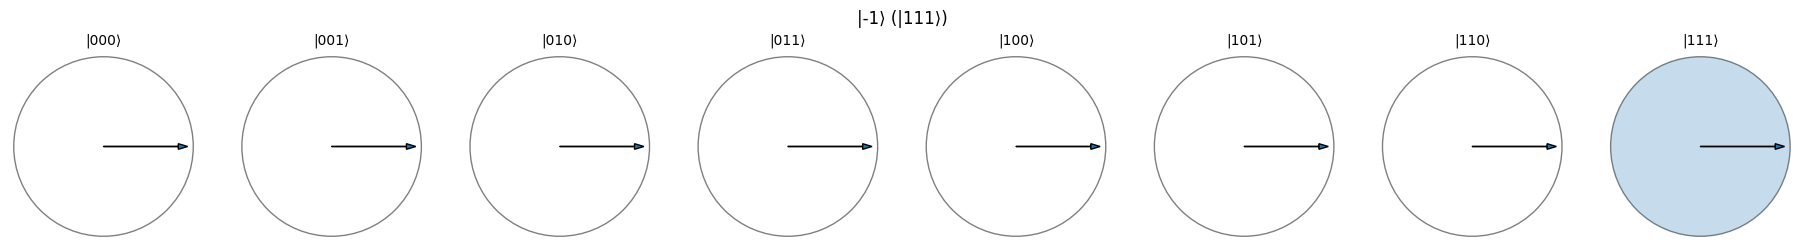

⚠️ Overflow: amplitude from basis state 7 wrapped around to 0


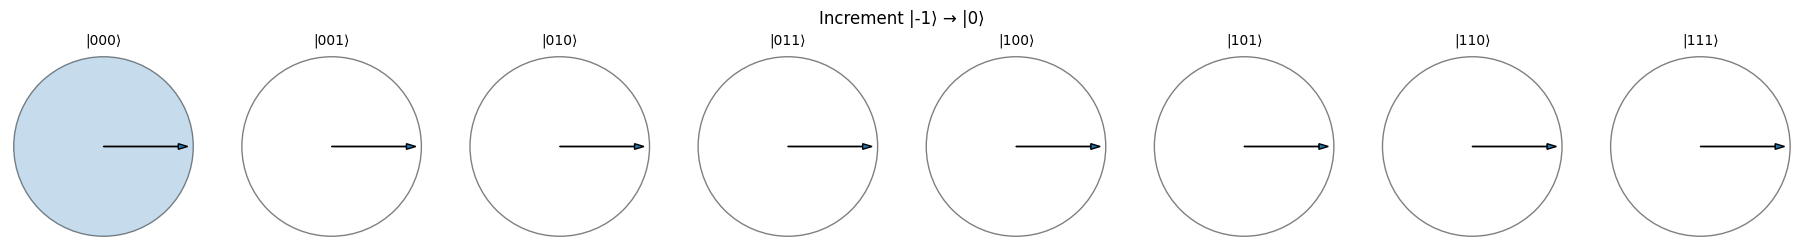

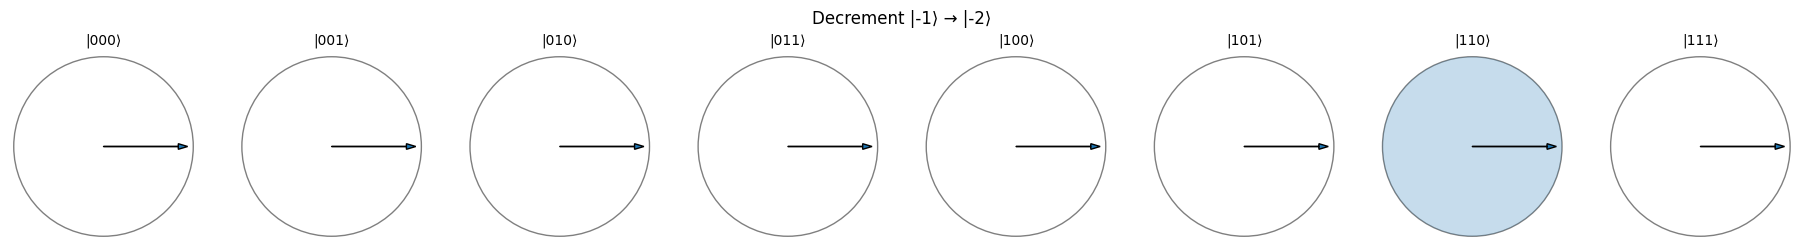

In [ ]:
# 3 qubits => 2^3 = 8 states => represent -4..+3
# Two's complement mapping:
# |000> = 0
# |001> = 1
# |010> = 2
# |011> = 3
# |100> = -4
# |101> = -3
# |110> = -2
# |111> = -1

# Start in |-1> = |111>
sv = np.array([0,0,0,0,0,0,0,1], dtype=np.complex128)

qs = QubitSystem(sv, label="|-1⟩ (|111⟩)")
qs.viz_circle()

# Increment: -1 → 0
sv_inc = increment(sv)
qs_inc = QubitSystem(sv_inc, label="Increment |-1⟩ → |0⟩")
qs_inc.viz_circle()

# Decrement: -1 → -2
sv_dec = decrement(sv)
qs_dec = QubitSystem(sv_dec, label="Decrement |-1⟩ → |-2⟩")
qs_dec.viz_circle()


# Task 2 — Quantum Fourier Transform

## Task 2.1 - QFT and Preparation Circuit

In [ ]:
# Install packages
!pip install "qiskit[all]~=2.1" "qiskit-ibm-runtime~=0.40"
!pip install qiskit-ibm-runtime
!pip install qiskit-aer

# Import IBM Quantum runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

TOKEN = "MWZ1LaXEw2yEimK7gS0p7DPXzFExPBsQ5Lhhs1B5JBRx"
INSTANCE = None  # optional

# Initialize service
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
)

# Quick sanity check
backends = service.backends(operational=True, simulator=False)
print("OK. Found", len(backends), "real backends. Example:", [b.name for b in backends[:3]])

# Save account for future sessions
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
    set_as_default=True,
    overwrite=True,
)
print("Saved default account for this runtime.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 35.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=e360349ea1fe3eed439aa33d795b07a6a50891fa11b029bec3279072647207e1
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
  Created wheel 

qiskit_runtime_service._discover_account:WARNING:2025-10-08 14:55:59,502: Loading account with the given token. A saved account will not be used.


IBMInputValueError: 'No matching instances found for the following filters: .'

In [ ]:
# Quantum Circuit and QFT
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

# Create 4-qubit circuit
n = 4
qc = QuantumCircuit(n)

# Define QFT (Hadamard starts from last qubit and goes up,
# controlled rotations start at π/2 and decrease)
def qft(circuit, qubits):
    n = len(qubits)
    for j in reversed(range(n)):  # start from last qubit
        circuit.h(qubits[j])
        for k in range(j-1,-1,-1):  # controlled rotations
            # Start with π/2, then π/4, π/8, ...
            angle = -np.pi / (2 ** (j - k))   # old formula
            if angle == np.pi:               # avoid π, make it π/2
                angle = np.pi / 2
            circuit.cp(angle, qubits[k], qubits[j])
        #circuit.barrier()
    # Swap qubits (bit reversal)
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - i - 1])


    return circuit

qc = qft(qc, list(range(n)))
print(qc.draw(output='text', fold=-1, justify='left'))

# Simulate using AerSimulator
backend = AerSimulator()
job = backend.run(qc)
result = job.result()
statevector = Statevector.from_instruction(qc)

# Plot amplitudes
plot_state_city(statevector.data)
plt.show()

# Print amplitudes and phases
for i, amp in enumerate(statevector.data):
    magnitude = np.abs(amp)
    phase = np.angle(amp)
    print(f"|{i:04b}⟩ : amplitude = {magnitude:.3f}, phase = {phase:.3f} rad")


The QFT preparation involves Hadamards on all 4 qubits to create an equal superposition. Further, a single-qubit phase flips sign of states where that qubit = 1.

The QFT itself involves repeated pattern of Hadarmards on a qubit followed by controlled phase rotations from less-significant qubits with exponentially smaller angles (−90°, −45°, −22.5°).

The Second H gate in the graph is plotted before the -pi/8 phase transition, however it is not coded that way. Moreover adding a barrier after the nested loop, seems to give us the correct ordering of the gate. All of this leads us to conclude that something is wrong with the plot function only, but not the qft itself.



## Task 2.2 - Circle Notation

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
#from qiskit_aer.visualization import QubitSystem

# Initialize a 4-qubit quantum circuit
n = 4
prep_qc = QuantumCircuit(n)
qubits = list(range(n))

# Apply Hadamard gates to all qubits
for i in qubits:
    prep_qc.h(i)

# Apply phase gate to qubit 1
prep_qc.p(np.pi, qubits[1])

# Convert the circuit to a statevector
prep_sv = sv_from_circ(prep_qc)

# Visualize the state using circle notation
QubitSystem(prep_sv, label="Prepared State").viz_circle()

qc_after_qft = qft(prep_qc, qubits)

# Convert the circuit to a statevector
QFT_SV = sv_from_circ(qc_after_qft)

# Visualize the state using circle notation
QubitSystem(QFT_SV, label="State after QFT").viz_circle()


To answer the question of 2.2:
The circuit prepares a uniform superposition of all 16 states, but with a sign flip for all states where qubit 1 = 1

## Task 2.3 - Discussion

After the QFT is performed, some states interfere constructively (amplitudes increase), while some states interfere destructively (amplitudes approach zero). QFT outputs amplitudes encoded in quantum state (phases), while the traditional DFT and FFT, outputs amplitudes as N complex values.


# Bonus Task — Discrete Quantum Walk on a Line

## Task B.1 - Quantum Walk Implementation

## Task B.2 - Measurement Distribution

## Task B.3 - Initial Condition in Superposition

## Task B.4 - ROTY and Biased Quantum Walk

# AI Assistance Disclosure

Generally, ChatGPT was used to guide us in the debugging of code.

**Per-Task Usage:**  
- **Task 1:**

Query: "i dont see any visual change with the circle notations displayed"

Answer: "You did...

Each basis state has probability 1/4.

So each circle will show a disk of equal size (since all probs = 0.25).

The arrows all point the same way (phase = 0).

👉 That’s why it “looks the same” across circles."

- **Task 2:**

Query: "help me interpret the circuit in the image below..."

Answer: "Each qubit gets a Hadamard... That creates an equal superposition of all basis states so amplitudes have equal magnitude.

The diagram also shows a phase/rotation applied during prep..."

- **Bonus:**

**Validation:** AI outputs were tested in the notebook, adapted to match variable names and environment, and checked with documentation and sample data to ensure correctness.

